# Utilities

In [5]:
import os, sys
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath('.')))
sys.path.append(parent_dir)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

class Analyzer:
    
    def __init__(self, network):
        self.network = network
        
    def get_degree_distribution(self):
        "Returns the plot of the degree distribution with a log-log scale"
        
        N = self.network.number_of_nodes()
        degrees = [self.network.in_degree(n) for n in self.network.nodes()] if self.network.is_directed() else [self.network.degree(n) for n in self.network.nodes()]
        
        N_k = {}
        for k in degrees:
            if k not in N_k:
                N_k[k] = 1
            else:
                N_k[k] += 1
                
        p_k = {}
        for k in N_k:
            p_k[k] = N_k[k] / N
        
        # Plotting in log-log scale
        plt.figure(figsize=(8, 6))
        plt.loglog(list(p_k.keys()), list(p_k.values()), marker='o', linestyle='None', color='b')
        plt.title('Log-log Degree Distribution')
        plt.xlabel('Degree')
        plt.ylabel('Frequency')
        plt.grid(True)

        return plt

# Random Graphs

In [ ]:
from networks_gen import randomG
import random

n = 25000

# take p randomly between 1/24999 and 1
p = random.uniform(1/(n-1), 0.01)

g1 = randomG(n, p)
analyzer_g1 = Analyzer(g1)
plt = analyzer_g1.get_degree_distribution()
plt.show()

In [ ]:
print(len(g1.edges()))
print(len(g1.nodes()))

In [ ]:
# save the graph
print(p)

In [ ]:
# save the graph
print(stream_diam(g1))

# Configuration model

In [ ]:
import networkx as nx
import numpy as np

degree_distribution = [d for _, d in G.degree()]

min = np.min(degree_distribution)
max = np.max(degree_distribution)

# normalize the degree distribution beteen 0 and max - min
normalized_degree_distribution = [d - min for d in degree_distribution]

if np.sum(normalized_degree_distribution) % 2 != 0:
    normalized_degree_distribution[0] += 1

# Generate the small graph
small_graph = nx.configuration_model(normalized_degree_distribution[:3000])

# Compute the degree distribution of the small graph
analyzer_g2 = Analyzer(small_graph)
plt = analyzer_g2.get_degree_distribution()
plt.show()

In [ ]:
nx.draw_networkx(small_graph, with_labels=False, linewidths=0.01, node_size=1, width=0.1)
plt.show()

# Preferential Attachment

In [ ]:
from networks_gen import preferentialG
import random

# generate a preferential graph for n = 25000 and different values of p (between 0 excluded and 1 included) and plot the degree distribution for each graph
n = 25000

ps = [0.01, 0.1, 0.5, 0.7, 1]

# take p randomly between 1/24999 and 1
for p in ps:
    g2 = preferentialG(n, p)
    analyzer_g2 = Analyzer(g2)
    print(len(g2.edges()))
    plt = analyzer_g2.get_degree_distribution()
    plt.show()

# Generalized Watts-Strogatz

In [ ]:
import networkx as nx
import numpy as np
from networks_gen import GenWS2DG

# degree_distribution = [d for _, d in G.degree()]

# min = np.min(degree_distribution)
# max = np.max(degree_distribution)

# # normalize the degree distribution beteen 0 and max - min
# normalized_degree_distribution = [d - min for d in degree_distribution]

# normalized_degree_distribution = normalized_degree_distribution[:3000]

# if np.sum(normalized_degree_distribution) % 2 != 0:
#     normalized_degree_distribution[-1] += 1

# Generate the small graph
small_graph = GenWS2DG(2500, 1, 1000, 1)

# Compute the degree distribution of the small graph
analyzer_g2 = Analyzer(small_graph)
plt = analyzer_g2.get_degree_distribution()
plt.show()

# Affiliation Networks

In [15]:
import networkx as nx

G = nx.read_edgelist('net_2', nodetype=int)

In [16]:
print(G.neighbors(1))

In [24]:
import numpy as np

n = len(G.nodes())
m = 4
learning_rate = 0.01
epsilon = 1e-8  
max_iter = 100
gradient = np.inf

F = np.random.rand(n, m)

sum_v = np.sum(F[i] for i in range(n))

def log_likelihood(u, F, G, sum_v):
    sum_1 = np.sum((F[v] * np.exp(-np.dot(F[u], np.transpose(F[v])))/(1 - np.exp(-np.dot(F[u], np.transpose(F[v]))) + epsilon) for v in G.neighbors(u)))
    sum_2 = sum_v - F[u] - np.sum(F[v] for v in G.neighbors(u))
    return sum_1 - sum_2

while max_iter > 0 and gradient > 0.01:
    for row in range(n):
        gradient = np.gradient(log_likelihood(row, F, G, sum_v))
        F[row] = F[row] + learning_rate * gradient
        F[row] = np.maximum(F[row], 0)
    max_iter -= 1
    
# normalize F between 0 and 1
F = F / np.max(F)
    
print(F)

/var/folders/98/yrs1tbqs4mn9v5k3tpqcr4_m0000gn/T/ipykernel_17347/357382115.py:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_v = np.sum(F[i] for i in range(n))
/var/folders/98/yrs1tbqs4mn9v5k3tpqcr4_m0000gn/T/ipykernel_17347/357382115.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_1 = np.sum((F[v] * np.exp(-np.dot(F[u], np.transpose(F[v])))/(1 - np.exp(-np.dot(F[u], np.transpose(F[v]))) + epsilon ) for v in G.neighbors(u)))
/var/folders/98/yrs1tbqs4mn9v5k3tpqcr4_m0000gn/T/ipykernel_17347/357382115.py:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_2 = sum_v - F[u] -

[[3.57003817 1.45766387 0.         0.06002004]
 [0.36105477 0.51309732 0.29209206 1.61370563]
 [2.75950598 0.36375968 0.         1.03938374]
 ...
 [2.57134356 2.46927699 1.18149014 0.44091635]
 [0.41419408 1.18776261 1.72734306 0.6192846 ]
 [1.24852844 2.33689554 0.         0.        ]]


In [4]:
from networks_gen import affiliationG

n = len(G.nodes())
m = 4
q = 0.5
c = 4
p = 0.5
s = 10

B = affiliationG(n, m, q, c, p, s)

In [7]:
parameters = [n, m, q, c, p, s]

In [ ]:
# convex optimization technique 
from scipy.optimize import minimize
import numpy as np

def likelihood_function(*parameters):
    # compute the likelihood function
    # return the value of the likelihood function
    # \argmax_{x_c} \sum_{(u,v) \in E} \log(1-e^{-\sum_{k \in C_{u,v}} x_k})}}}) - \sum_{(u,v) \not in E} \sum_{k \in C_{u,v}} x_k
    return np.sum([np.log(1 - np.exp(-np.sum([parameters[k] for k in B[u][v]]))) for u, v in G.edges()]) - np.sum([np.sum([parameters[k] for k in B[u][v]]) for u, v in G.edges()])

def loss_function(*parameters):
    # we maximize the likelihood function to find the best parameters, so we minimize the negative of the likelihood function
    return -likelihood_function(*parameters)

def update_parameters(*parameters, B):

    # Optimize the loss function using gradient descent
    result = minimize(loss_function, *parameters, method='BFGS')
    optimized_parameters = result.x  # The optimized parameters obtained from the optimization

    return optimized_parameters

def update_graph(G, B, pc):
    # update the graph G using the parameters pc sing the Metropolis-Hastings algorithm with leave, join, and switch transitions.
    # return the updated graph
    pass

In [ ]:
num_iterations = 100

for i in range(num_iterations):
    
    # 1. update parameters while keeping the graph fixed
    pc = update_parameters(G, B)
    
    # 2. update the graph while keeping the parameters fixed
    B = update_graph(G, B, pc)

In [16]:
comm = nx.community.louvain_communities(G)

print(len(comm))

for c in comm:
    print(len(c))

4
5448
5199
8089
6264


In [17]:
from networks_gen import affiliationG
import math

# n = number of nodes
# m = number of communities
# q = probability of preferential affiliation to communities
# c = maximum number of communities to which one node may be affiliated
# p = probability of an inter-community edge (strong ties)
# s = number of out-community edges (weak ties)

n = len(G.nodes()) # n = number of nodes
m = len(comm) # m = number of communities
c = 3

# for each community compute the number of out-community edges
out_edges = {}
in_edges = {}

# for each node save the number of out-community edges and the number of in-community edges as well as the community to which it belongs
for i, c in enumerate(comm):
    for n in c:
        out_edges[(n, i)] = 0
        in_edges[(n, i)] = 0
        for n2 in G.neighbors(n):
            if n2 not in c:
                out_edges[(n, i)] += 1
            else:
                in_edges[(n, i)] += 1

In [18]:
# for each community compute the mean number of out-community edges of its nodes
s = 0
for i, c in enumerate(comm):
    mean = 0
    for n in c:
        mean += out_edges[(n, i)]
    mean /= len(c)
    s += mean
s /= m
s = math.ceil(s)

print('Mean number of out-community edges of nodes in the whole network')
print(s)
    
# for each node compute the probability of having an in-community edge
p_in = {}
for i, c in enumerate(comm):
    for n in c:
        if (n, i) in out_edges and (n, i) in in_edges:
            p_in[(n, i)] = in_edges[(n, i)] / (in_edges[(n, i)] + out_edges[(n, i)])
        elif (n, i) in in_edges:
            p_in[(n, i)] = 1
        else:
            p_in[(n, i)] = 0
            
# for each community compute the probability of having an inter-community edge
p_inter = {}
for i, c in enumerate(comm):
    # make the mean of the probability of having an inter-community edge for each node in the community
    mean = 0
    for n in c:
        mean += p_in[(n, i)]
    mean /= len(c)
    p_inter[i] = mean
            
# weighted mean of the probability of having an inter-community edge for each community
p = 0
for i in p_inter:
    p += p_inter[i] * len(comm[i])
p /= len(G.nodes())
        
print('Probability of having an inter-community edge')
print(p)

Mean number of out-community edges of nodes in the whole network
996
Probability of having an inter-community edge
0.48143820552129085


3148723


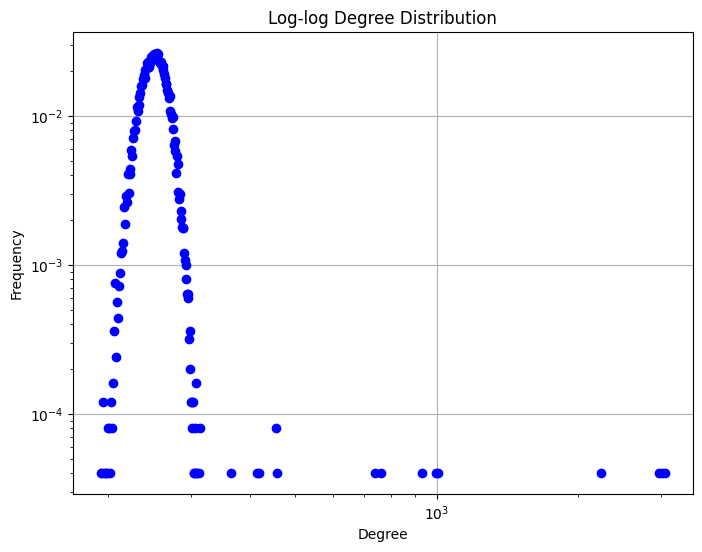

3929264


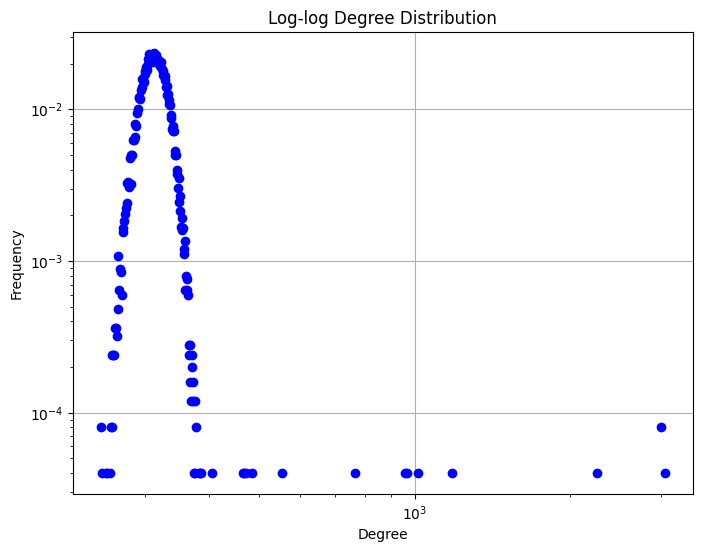

6158399


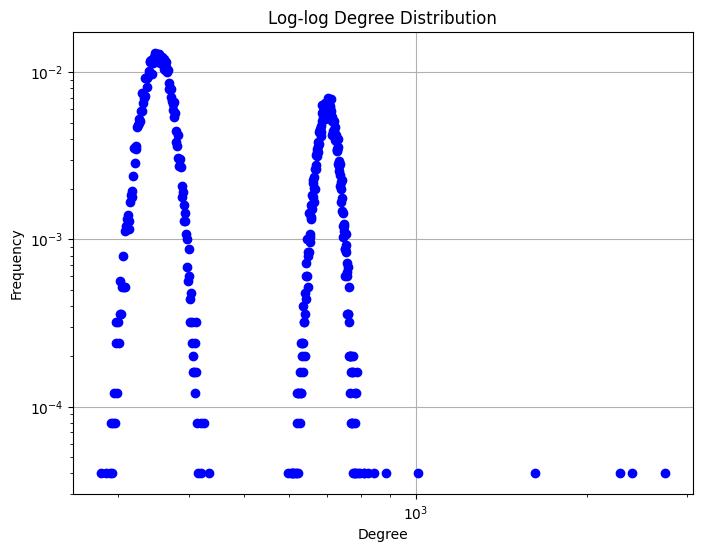

7644398


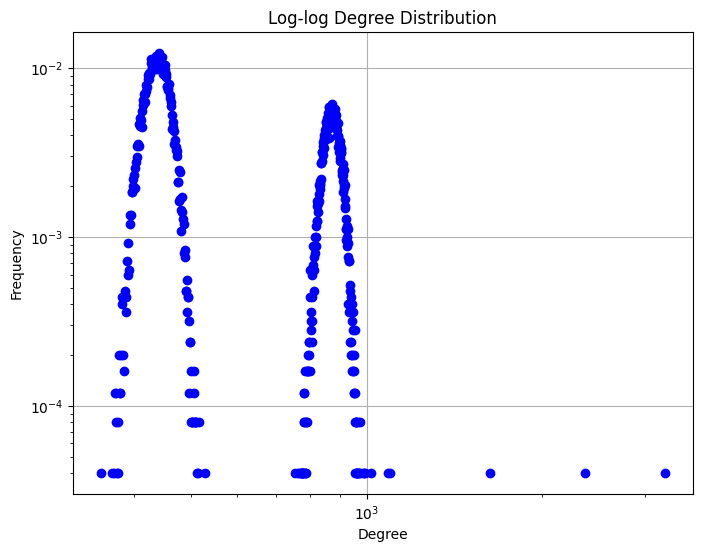

9198646


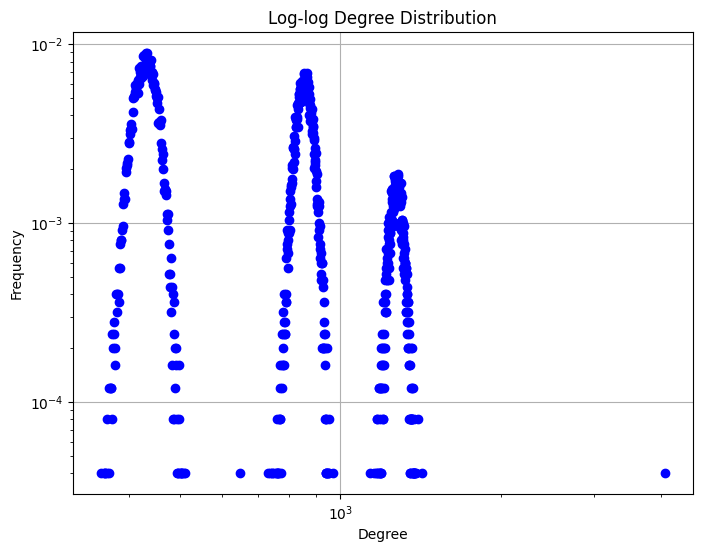

11531282


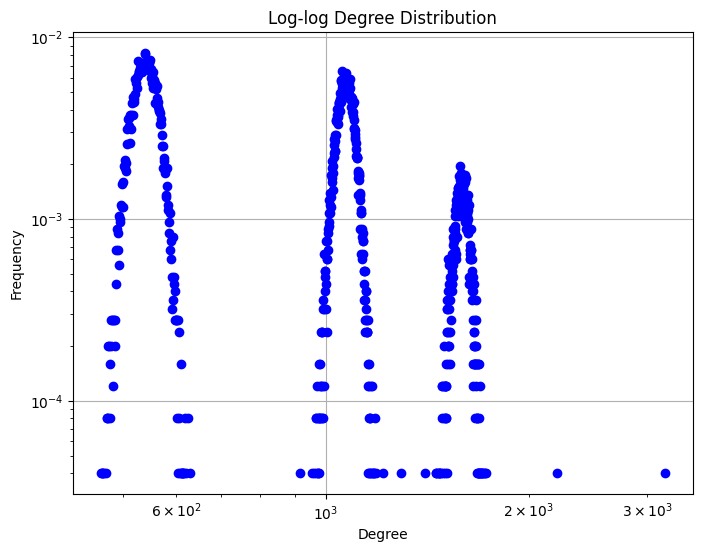

In [19]:
from networks_gen import affiliationG

n = len(G.nodes()) # n = number of nodes
m = 4
c_values = range(1, m)
q = 0.12
p_values = [0.04, 0.05]

for c in c_values:
    for p in p_values:
        graph = affiliationG(n, m, q, c, p, s)
        print(len(graph.edges()))
        analyzer = Analyzer(graph)
        plt = analyzer.get_degree_distribution()
        plt.show()